# Chartinfo2024 Dataset Validation
This notebook uses the ChartInfo 2024 dataset to verify the extraction algorithm.
The goal is to obtain various metrics to analyze performance and identify areas for improvement.
## Dataset Information
**Dataset:** ChartInfo 2024  
**Source:** [GitHub Repository](https://github.com/kdavila/CHART_Info_2024)  
**Paper:** CHART-Info 2024: A dataset for Chart Analysis and Recognition


## Import

In [4]:
# Standard library imports
import os
import random as rd
# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import auc
import seaborn as sns

# Multiprocessing / concurrency
import asyncio
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed

# Project-specific imports
import PDE
import PDE.MAE_validation as MAE


## Validation for One Image


Processing: PMC5615688___materials-10-01033-g010.jpg
Validation results:


,Plot Type,Image Name,Series Name,Extracted Name,MAE,MAE rel,Left_miss_rel,Right_miss_rel,x_cutoff,Match Method,...,Frechet Distance,Hausdorff Distance,Coverage X,Coverage Y,Data Density Ratio,Missing Regions Count,Noise Level Diff,Smoothness Diff,Outlier Ratio Diff,Composite Similarity Score
0,scatter,PMC5615688___materials-10-01033-g010,v=1.5 mm/min,v=1.5 mm/min,2.456827,0.029877,0.000594,-0.092692,None,exact_match,...,None,6.427333,0.997812,0.977824,0.746732,0,0.0,26.127070,0,0.990446
1,scatter,PMC5615688___materials-10-01033-g010,v=2.0 mm/min,v=2.0 mm/min,1.758893,0.021390,0.001783,-0.003565,None,exact_match,...,None,3.737421,0.996721,0.993000,0.996732,0,0.0,29.574637,0,0.992473
2,scatter,PMC5615688___materials-10-01033-g010,v=2.5 mm/min,v=2.5 mm/min,0.759219,0.009233,-0.001783,-0.090909,None,exact_match,...,None,0.313488,1.000000,0.995289,0.854342,0,0.0,0.568561,0,0.997230



Callback DataFrame:


,call_id,step,model,Input tokens,Output tokens,Total tokens,Cost (USD),image_name
0,1,extract_plot_type,gemini-2.0-flash,2013,13,2026,0.000207,PMC5615688___materials-10-01033-g010.jpg
1,2,extract_description,gemini-2.0-flash,4734,128,4862,0.000525,PMC5615688___materials-10-01033-g010.jpg
2,3,extract_data,gemini-2.0-flash,2158,237,2395,0.000311,PMC5615688___materials-10-01033-g010.jpg


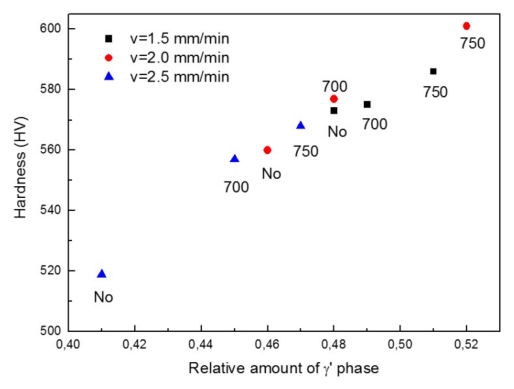

In [ ]:
import matplotlib.pyplot as plt

# Define dataset paths
dataset_path = r"..\Dataset\CHARTINFO_2024"
images_path = os.path.join(dataset_path, "Images")
plot_type = 1  # from 0 to 4

# Get a random image from the selected plot type
images = os.listdir(os.path.join(dataset_path, list_of_plots[plot_type]))
image = rd.choice(images)

ext = image.split(".")[-1]
image_path = os.path.join(Dataset_path, list_of_plots[plot_type], image)

# Display the image
plt.imshow(plt.imread(image_path))
plt.axis('off')

def process_single_image_with_extractor(image_path, dataset_path):
    """
    Process an image with extraction and validation, using the plot_type from the extractor.
    If an error occurs, returns DataFrames with the image name and NaN/None values.
    """
    ext = image_path.split(".")[-1]
    plot_folder = os.path.basename(os.path.dirname(image_path))
    image_name = os.path.basename(image_path)

    gt_json_path = os.path.join(dataset_path, "annotations_JSON", plot_folder, image_name.replace(ext, "json"))
    extracted_json_path = os.path.join(dataset_path, "output", plot_folder, image_name.replace('.'+ext, ""), image_name.replace(ext, "json"))

    # Directory to save plots
    save_dir = os.path.join(dataset_path, "output", plot_folder, image_name.replace('.'+ext, ""))

    extractor = PDE.PlotDataExtractor(image_path)
    try:
        data = extractor.run()
        plot_type = extractor.res1.plot_type.value

        os.makedirs(os.path.dirname(extracted_json_path), exist_ok=True)
        extractor.save(extracted_json_path)

        # Validation with global bounds
        results_df = MAE.compare_single_image(
            gt_json_path=gt_json_path,
            extracted_json_path=extracted_json_path,
            image_name=image_name.replace('.'+ext, ''),
            plot_type=plot_type,
            save=True,
            save_dir=save_dir,
            plot=False
        )

        callback_df = extractor.callback_df.copy()
        callback_df['image_name'] = image_name
        
        return results_df, callback_df
        
    except Exception as e:
        print(f"Error during extraction: {e}")

        # Error DataFrame with ALL 40 COLUMNS to match successful results
        error_results_df = pd.DataFrame({
            # Basic columns
            'Plot Type': [plot_folder],
            'Image Name': [image_name.replace('.'+ext, '')],
            'Series Name': [np.nan],
            'Extracted Name': [np.nan],
            'MAE': [np.nan],
            'MAE rel': [np.nan],
            'Left_miss_rel': [np.nan],
            'Right_miss_rel': [np.nan],
            'x_cutoff': [None],
            'Match Method': ['extraction_error'],
            'Match Score': [0.0],
            
            # GT statistics columns
            'GT Nb Points': [np.nan],
            'GT X Min': [np.nan],
            'GT X Max': [np.nan],
            'GT X Std': [np.nan],
            'GT X Range': [np.nan],
            'GT Y Min': [np.nan],
            'GT Y Max': [np.nan],
            'GT Y Std': [np.nan],
            'GT Y Range': [np.nan],
            
            # Extracted statistics columns
            'Extracted Nb Points': [np.nan],
            'Extracted X Min': [np.nan],
            'Extracted X Max': [np.nan],
            'Extracted X Std': [np.nan],
            'Extracted X Range': [np.nan],
            'Extracted Y Min': [np.nan],
            'Extracted Y Max': [np.nan],
            'Extracted Y Std': [np.nan],
            'Extracted Y Range': [np.nan],
            
            # Distribution metrics
            'Skewness Diff': [np.nan],
            'Kurtosis Diff': [np.nan],
            'Percentile 90 Diff': [np.nan],
            'Percentile 10 Diff': [np.nan],
            'IQR Diff': [np.nan],
            
            # Trend metrics
            'Monotonicity Preserved': [np.nan],
            'Trend Correlation': [np.nan],
            'Turning Points Diff': [np.nan],
            
            # Shape metrics
            'Shape Similarity': [np.nan],
            'Frechet Distance': [None],
            'Hausdorff Distance': [np.nan],
            
            # Coverage metrics
            'Coverage X': [np.nan],
            'Coverage Y': [np.nan],
            'Data Density Ratio': [np.nan],
            'Missing Regions Count': [np.nan],
            
            # Quality metrics
            'Noise Level Diff': [np.nan],
            'Smoothness Diff': [np.nan],
            'Outlier Ratio Diff': [np.nan],
            
            # Composite score
            'Composite Similarity Score': [np.nan]
        })

        # Error callback DataFrame
        error_callback_df = pd.DataFrame({
            'call_id': [np.nan],
            'step': ['extraction_error'],
            'model': [np.nan],
            'Input tokens': [np.nan],
            'Output tokens': [np.nan],
            'Total tokens': [np.nan],
            'Cost (USD)': [0.0],
            'image_name': [image_name]
        })

        return error_results_df, error_callback_df

print(f"Processing: {os.path.basename(image_path)}")
# Test with a random image
results, callback_df = process_single_image_with_extractor(image_path, dataset_path)

if results is not None:
    print("Validation results:")
    display(results)
    print("\nCallback DataFrame:")
    display(callback_df)


## Extraction and Validation of a Dataset Sample
### Method and Pipeline

The pipeline processes 500 selected images from the ChartInfo 2024 dataset (100 per chart type: line, scatter, horizontal_bar, vertical_bar, vertical_box). The process uses a ThreadPoolExecutor with 6 workers to parallelize extraction via the Gemini 2.0 Flash API, followed by validation against ground truth annotations and saving results in Excel format.

### Performance Results

**Global Metrics:**
- Images processed: 1041 series extracted from 500 images
- Processing time: 851.1 seconds (14 minutes)
- Mean relative MAE: 0.0985 (9.85% relative error)
- Total cost: $0.4960 USD (about $0.001 per image)

**Performance Example:**
Image PMC5615688 (scatter plot): 3 series extracted with relative MAE between 0.021-0.030, X coverage of 99.7-100%, and composite score of 0.990-0.997.

### Challenges and Identified Errors

**Types of errors by frequency:**

1. **Pydantic parsing errors** (15 occurrences): Null required fields (Number_of_Serie) and incorrect types (overlapping string instead of boolean)

2. **Series matching errors** (50 occurrences): "No matched x values between GT and EX" and numpy signature errors for distance calculations

3. **Metric calculation errors** (30 occurrences): Index out of bounds and empty DataFrames

### Conclusion

The pipeline demonstrates acceptable performance with a relative MAE of 9.85% for an automated system. The operational cost remains reasonable at $0.50 for 500 images. The main improvements needed concern strict validation of Pydantic fields, improved matching algorithms for categorical data, and robust handling of edge cases in metric calculations. The target objective would be to achieve a relative MAE below 5% with an extraction success rate above 95%.

In [ ]:
import concurrent.futures
from tqdm.auto import tqdm
import time

# Configuration of paths
dataset_path = r"..\Dataset\CHARTINFO_2024"
images_root = os.path.join(dataset_path, "images")
plot_types = ['line', 'scatter', 'horizontal_bar', 'vertical_bar', 'vertical_box']

# Collect the first 100 images per folder (per plot type)
all_image_paths = []
for plot_type in plot_types:
    folder = os.path.join(images_root, plot_type)
    if os.path.exists(folder):
        images_in_folder = []
        for img in os.listdir(folder):
            if img.lower().endswith(('.jpg', '.png', '.jpeg')):
                images_in_folder.append(os.path.join(folder, img))
        
        # Limit to 100 images per folder
        selected_images = images_in_folder[:100]
        all_image_paths.extend(selected_images)
        print(f"{plot_type}: {len(selected_images)}/{len(images_in_folder)}")

print(f"Total images: {len(all_image_paths)}")

def process_wrapper(image_path):
    """
    Wrapper for processing a single image.
    Handles exceptions and returns None if an error occurs.
    """
    try:
        return process_single_image_with_extractor(image_path, dataset_path)
    except Exception as e:
        print(f"Error: {os.path.basename(image_path)}: {e}")
        return None, None

# Multithreaded processing of all images
def process_all_images():
    """
    Processes all images in parallel using ThreadPoolExecutor.
    Returns lists of results and callback DataFrames.
    """
    results_list = []
    callback_list = []
    
    print("Starting processing")
    start_time = time.time()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        # Submit all image processing tasks
        futures = [executor.submit(process_wrapper, img_path) for img_path in all_image_paths]
        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), 
                          total=len(futures), 
                          desc="Processing"):
            results, callback_df = future.result()
            if results is not None:
                results_list.append(results)
            if callback_df is not None:
                callback_list.append(callback_df)
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    print(f"Time elapsed: {processing_time:.1f}s")
    print(f"Images processed: {len(results_list)}")
    
    return results_list, callback_list

# Run the processing pipeline
results_list, callback_list = process_all_images()

# Save results to Excel files
if results_list and callback_list:
    print(f"Saving {len(results_list)} results")
    
    final_results_df = pd.concat(results_list, ignore_index=True)
    final_callback_df = pd.concat(callback_list, ignore_index=True)
    
    excel_path = os.path.join(dataset_path, "Validation_results.xlsx")
    excel_path_cb = os.path.join(dataset_path, "validation_cost.xlsx")
    
    # Save validation results
    with pd.ExcelWriter(excel_path) as writer:
        final_results_df.to_excel(writer, sheet_name="Results", index=False)
    
    # Save callback/cost results
    with pd.ExcelWriter(excel_path_cb) as writer:
        final_callback_df.to_excel(writer, sheet_name="Callbacks", index=False)
    
    print(f"Results saved: {os.path.basename(excel_path)}")
    print(f"Callbacks saved: {os.path.basename(excel_path_cb)}")
    
    # Print summary statistics
    print("Statistics:")
    print(f"Images: {len(final_results_df)}")
    print(f"Total cost: ${final_callback_df['Cost (USD)'].sum():.4f}")
    if 'MAE rel' in final_results_df.columns:
        print(f"Mean relative MAE: {final_results_df['MAE rel'].mean():.4f}")
    
    print("Results preview:")
    display(final_results_df.head())
    
    print("Cost preview:")
    display(final_callback_df.head())
    
else:
    print("No results")


line: 100/1885
scatter: 100/644
horizontal_bar: 100/609
vertical_bar: 100/1748
vertical_box: 100/541
Total images: 500
Starting processing


Processing:   0%|          | 0/500 [00:00<?, ?it/s]

[ERROR] data_loading: DataFrames vides
Erreur dans similarity matching générique: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U2'), dtype('<U2')) -> None
[ERROR] validation_process: 'str' object has no attribute 'keys'
Erreur lors du traitement de l'image PMC1193525___pgen.0010015.g005: 'str' object has no attribute 'keys'
[ERROR] series_comparison: No matched x values between GT and EX.
[ERROR] series_comparison: No matched x values between GT and EX.
[ERROR] series_comparison: No matched x values between GT and EX.
[ERROR] series_comparison: No matched x values between GT and EX.
[ERROR] series_comparison: No matched x values between GT and EX.


## Validation Analysis

This section provides an optional comprehensive evaluation to:

1. **Assess algorithmic performance**: Evaluate the effectiveness of the extraction algorithm through quantitative metrics and statistical analysis
2. **Identify optimization opportunities**: Determine key areas for algorithmic improvement based on error patterns, performance bottlenecks, and metric correlations

The analysis encompasses error distribution analysis, correlation matrices, and principal component analysis to provide insights into the extraction pipeline's strengths and limitations.

In [5]:
# Open both Excel files with pandas
dataset_path = r"..\Dataset\CHARTINFO_2024"
excel_path = os.path.join(dataset_path, "Validation_results.xlsx")
excel_path_cb = os.path.join(dataset_path, "validation_cost.xlsx")

# Read the validation results and cost files into DataFrames
results_df = pd.read_excel(excel_path)
callback_df = pd.read_excel(excel_path_cb)
#fill na
where_no_error = (results_df["Match Method"]!='error') & (results_df["Match Method"]!='extraction_error')
# Fill Left_miss_rel and Right_miss_rel with 0
results_df.loc[where_no_error, ["Left_miss_rel","Right_miss_rel"]] = results_df.loc[where_no_error, ["Left_miss_rel","Right_miss_rel"]].fillna(0)
# Fill GT X Min with 1 if missing
results_df.loc[where_no_error, ["GT X Min"]] = results_df.loc[where_no_error, ["GT X Min"]].fillna(1)
# Calculate GT X Max from GT X Range when GT X Max is missing
mask_missing_max = where_no_error & results_df["GT X Max"].isna() & results_df["GT X Range"].notna()
results_df.loc[mask_missing_max, "GT X Max"] = results_df.loc[mask_missing_max, "GT X Range"]
# Fill x_cutoff with -1 if missing
results_df.loc[where_no_error, ["x_cutoff"]] = results_df.loc[where_no_error, ["x_cutoff"]].fillna(-1)
#Drop Frechet Distance because empty
results_df = results_df.drop(columns=['Frechet Distance'])
print("Preview of the results file:")
display(results_df)

print("Preview of the cost file:")
display(callback_df)

Preview of the results file:


,Plot Type,Image Name,Series Name,Extracted Name,MAE,MAE rel,Left_miss_rel,Right_miss_rel,x_cutoff,Match Method,...,Shape Similarity,Hausdorff Distance,Coverage X,Coverage Y,Data Density Ratio,Missing Regions Count,Noise Level Diff,Smoothness Diff,Outlier Ratio Diff,Composite Similarity Score
0,NaN,PMC1166547___1471-2156-6-26-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,extraction_error,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,line plot,PMC1164420___1471-2458-5-51-1,Female,Female,0.003261,0.006655,0.000000,-0.003445,-1.000,exact_match,...,0.999043,0.296948,1.000000,0.995380,0.996554,0.0,0.004113,0.000031,0.000000,0.994905
2,line plot,PMC1164420___1471-2458-5-51-1,male,male,0.005246,0.010706,0.000236,-0.002029,-1.000,exact_match,...,0.994705,1.089982,0.999764,0.979195,0.998206,0.0,0.018406,0.000283,0.000000,0.992283
3,line plot,PMC1090595___1471-2458-5-36-1,< 50 years,< 50 years,0.147258,0.062277,-0.002089,-0.141604,-1.000,exact_match,...,0.996415,3.965177,1.000000,0.920847,0.761162,0.0,0.093329,0.040660,0.013889,0.980600
4,line plot,PMC1090595___1471-2458-5-36-1,50-65 years,50-65 years,0.150942,0.063835,-0.004475,-0.142499,-1.000,exact_match,...,0.932489,4.000621,1.000000,1.000000,0.758245,0.0,0.188147,0.141465,0.013889,0.970431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,boxplot,PMC3386574___ijerph-09-01593-g002,[unnamed data series #0],Series 1,0.038025,0.003803,0.000000,0.000000,0.850,similarity_match_generic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,boxplot,PMC3386245___pgen.1002794.g002,controls,controls,0.025806,0.010417,0.000000,0.000000,1.000,exact_match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,boxplot,PMC3386245___pgen.1002794.g002,PD,PD,0.064625,0.026088,0.000000,0.000000,0.875,exact_match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,boxplot,PMC3407908___ijerph-09-02345-g004,T1,LWS ARM,NaN,NaN,NaN,NaN,NaN,error,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preview of the cost file:


,call_id,step,model,Input tokens,Output tokens,Total tokens,Cost (USD),image_name
0,NaN,extraction_error,NaN,NaN,NaN,NaN,NaN,PMC1166547___1471-2156-6-26-4.jpg
1,1.0,extract_plot_type,gemini-2.0-flash,1497.0,14.0,1511.0,0.000155,PMC1164420___1471-2458-5-51-1.jpg
2,2.0,extract_description,gemini-2.0-flash,3704.0,113.0,3817.0,0.000416,PMC1164420___1471-2458-5-51-1.jpg
3,3.0,extract_data,gemini-2.0-flash,2171.0,335.0,2506.0,0.000351,PMC1164420___1471-2458-5-51-1.jpg
4,1.0,extract_plot_type,gemini-2.0-flash,2013.0,14.0,2027.0,0.000207,PMC1090595___1471-2458-5-36-1.jpg
...,...,...,...,...,...,...,...,...
1457,2.0,extract_description,gemini-2.0-flash,3704.0,133.0,3837.0,0.000424,PMC3386245___pgen.1002794.g002.jpg
1458,3.0,extract_data,gemini-2.0-flash,2350.0,376.0,2726.0,0.000385,PMC3386245___pgen.1002794.g002.jpg
1459,1.0,extract_plot_type,gemini-2.0-flash,2013.0,14.0,2027.0,0.000207,PMC3407908___ijerph-09-02345-g004.jpg
1460,2.0,extract_description,gemini-2.0-flash,4736.0,99.0,4835.0,0.000513,PMC3407908___ijerph-09-02345-g004.jpg


In [6]:

def plot_mae_auc(Metrics, N=50, plot=True):
    from sklearn.metrics import auc
    X_AUC = []
    Y_AUC = []
    for i in np.arange(0, 1, 1/N):
        before_treshold = Metrics[Metrics < i].count()
        total = Metrics.count()
        ratio = before_treshold / total
        Y_AUC.append(ratio)
        X_AUC.append(i)
    auc_value = auc(X_AUC, Y_AUC)
    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        Metrics.plot.hist(bins=N, alpha=0.7, ax=ax1)
        ax1.set_xlabel('MAE rel')
        ax1.set_ylabel('Count')
        ax1.set_title('Histogram & AUC Curve')
        ax2.plot(X_AUC, Y_AUC, color='red', label=f'AUC = {auc_value:.3f}')
        ax2.set_ylabel('Ratio of points below threshold', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        fig.legend(loc='upper right')
        plt.show()
    return auc_value
no_na_results_df = results_df.dropna(subset=['MAE rel'])


In [7]:
class analysis_df:
    def __init__(self, results_df, callback_df, version):
        import time
        self.results_df = results_df
        self.callback_df = callback_df
        self.version = version
        self.benchmark_dict = {
            'Date': time.strftime("%Y-%m-%d"),
            'Time': time.strftime("%H:%M:%S"),
            'Version': self.version,
            "Validation error ratio": self.results_df['Match Method'].str.contains('error').sum() / len(self.results_df),
            "Extraction error ratio": self.results_df['Match Method'].str.contains('extraction_error').sum() / len(self.results_df),
            'AUC on Relative MAE': self.auc(self.results_df['MAE rel']),
            'Mean relative MAE': self.results_df['MAE rel'].mean(),
            '0.95 relative MAE': self.results_df['MAE rel'].quantile(0.95),
            'Median relative MAE': self.results_df['MAE rel'].median(),
            'Std relative MAE': self.results_df['MAE rel'].std(),
            'Mean relative MAE (line)': self.results_df[self.results_df['Plot Type'] == 'line plot']['MAE rel'].mean(),
            'Mean relative MAE (scatter)': self.results_df[self.results_df['Plot Type'] == 'scatter']['MAE rel'].mean(),
            'Mean relative MAE (bar)': self.results_df[self.results_df['Plot Type'] == 'bar']['MAE rel'].mean(),
            'Mean relative MAE (boxplot)': self.results_df[self.results_df['Plot Type'] == 'boxplot']['MAE rel'].mean(),
            'Extracted/GT points ratio': self.results_df['Extracted Nb Points'].sum() / self.results_df['GT Nb Points'].sum() if self.results_df['GT Nb Points'].sum() > 0 else None,
            'Total cost (USD)': self.callback_df['Cost (USD)'].sum(),
            'Mean cost per image': self.callback_df['Cost (USD)'].mean(),
            'Mean tokens per image': self.callback_df['Total tokens'].mean(),
            'Mean skewness diff': self.results_df['Skewness Diff'].mean(),
            'Mean kurtosis diff': self.results_df['Kurtosis Diff'].mean(),
            'Mean percentile 90 diff': self.results_df['Percentile 90 Diff'].mean(),
            'Mean percentile 10 diff': self.results_df['Percentile 10 Diff'].mean(),
            'Mean IQR diff': self.results_df['IQR Diff'].mean(),
            'Mean monotonicity preserved': self.results_df['Monotonicity Preserved'].mean(),
            'Mean trend correlation': self.results_df['Trend Correlation'].mean(),
            'Mean turning points diff': self.results_df['Turning Points Diff'].mean(),
            'Mean shape similarity': self.results_df['Shape Similarity'].mean(),
            'Mean Hausdorff distance': self.results_df['Hausdorff Distance'].mean(),
            'Mean coverage X': self.results_df['Coverage X'].mean(),
            'Mean coverage Y': self.results_df['Coverage Y'].mean(),
            'Mean data density ratio': self.results_df['Data Density Ratio'].mean(),
            'Mean missing regions count': self.results_df['Missing Regions Count'].mean(),
            'Mean noise level diff': self.results_df['Noise Level Diff'].mean(),
            'Mean smoothness diff': self.results_df['Smoothness Diff'].mean(),
            'Mean outlier ratio diff': self.results_df['Outlier Ratio Diff'].mean(),
            'Composite similarity score': self.results_df['Composite Similarity Score'].mean() if 'Composite Similarity Score' in self.results_df.columns else None,
            'Catastrophic error ratio': self.results_df[self.results_df['MAE rel'] > 1.0].shape[0] / self.results_df.shape[0],
            'Severe error ratio': self.results_df[self.results_df['MAE rel'] > 0.5].shape[0] / self.results_df.shape[0],
            'Acceptable error ratio': self.results_df[self.results_df['MAE rel'] < 0.1].shape[0] / self.results_df.shape[0],
            'Mean relative MAE (simple charts)': self.results_df[self.results_df['GT Nb Points'] < 20]['MAE rel'].mean() if not self.results_df[self.results_df['GT Nb Points'] < 50].empty else None,
            'Mean relative MAE (complex charts)': self.results_df[self.results_df['GT Nb Points'] >= 20]['MAE rel'].mean() if not self.results_df[self.results_df['GT Nb Points'] >= 50].empty else None
        }
        
    def auc(self, Series: pd.Series) -> float:
        """
        Takes a DataFrame column and computes the AUC
        """
        X_AUC = []
        Y_AUC = []
        for i in np.arange(0, 1, 0.01):
            before_treshold = Series[Series < i].count()
            total = Series.count()
            ratio = before_treshold / total
            Y_AUC.append(ratio)
            X_AUC.append(i)
        auc_value = auc(X_AUC, Y_AUC)
        return auc_value
    def df(self):
        """
        Returns a DataFrame with the analysis results
        """
        df = pd.DataFrame(self.benchmark_dict, index=[0])
        return df
    
    def save_analysis(self, directory: str):
        """
        Saves the analysis DataFrame to an Excel file
        """
        file_path = os.path.join(directory, f"benchmark_results.xlsx")
        # Check if file exists, if not create it with an empty sheet
        if not os.path.exists(file_path):
            # Create new file with analysis sheet
            with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
                self.df().to_excel(writer, sheet_name="analysis", index=False)

        else:
            existing_df = pd.read_excel(file_path, sheet_name="analysis",dtype={'Version': str})
            if self.version in list(existing_df['Version'].values):
                # Remove existing version
                existing_df = existing_df[existing_df['Version'] != self.version]
            combined_df = pd.concat([existing_df, self.df()], ignore_index=True)
            with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
                combined_df.to_excel(writer, sheet_name="analysis", index=False)
        
        print(f"Analysis saved in {file_path}")

# Afficher les résultats
analysis = analysis_df(results_df, callback_df, version="1.0")
display(analysis.df())
analysis.save_analysis(dataset_path)


,Date,Time,Version,Validation error ratio,Extraction error ratio,AUC on Relative MAE,Mean relative MAE,0.95 relative MAE,Median relative MAE,Std relative MAE,...,Mean missing regions count,Mean noise level diff,Mean smoothness diff,Mean outlier ratio diff,Composite similarity score,Catastrophic error ratio,Severe error ratio,Acceptable error ratio,Mean relative MAE (simple charts),Mean relative MAE (complex charts)
0,2025-08-16,19:51:32,1.0,0.060519,0.018252,0.891379,0.098543,0.460061,0.037213,0.161373,...,0.917098,519.381314,3.452391e+08,0.035955,0.850345,0.0,0.039385,0.694524,0.098987,0.096462


Analysis saved in ..\Dataset\CHARTINFO_2024\benchmark_results.xlsx


### Matrices des corélations

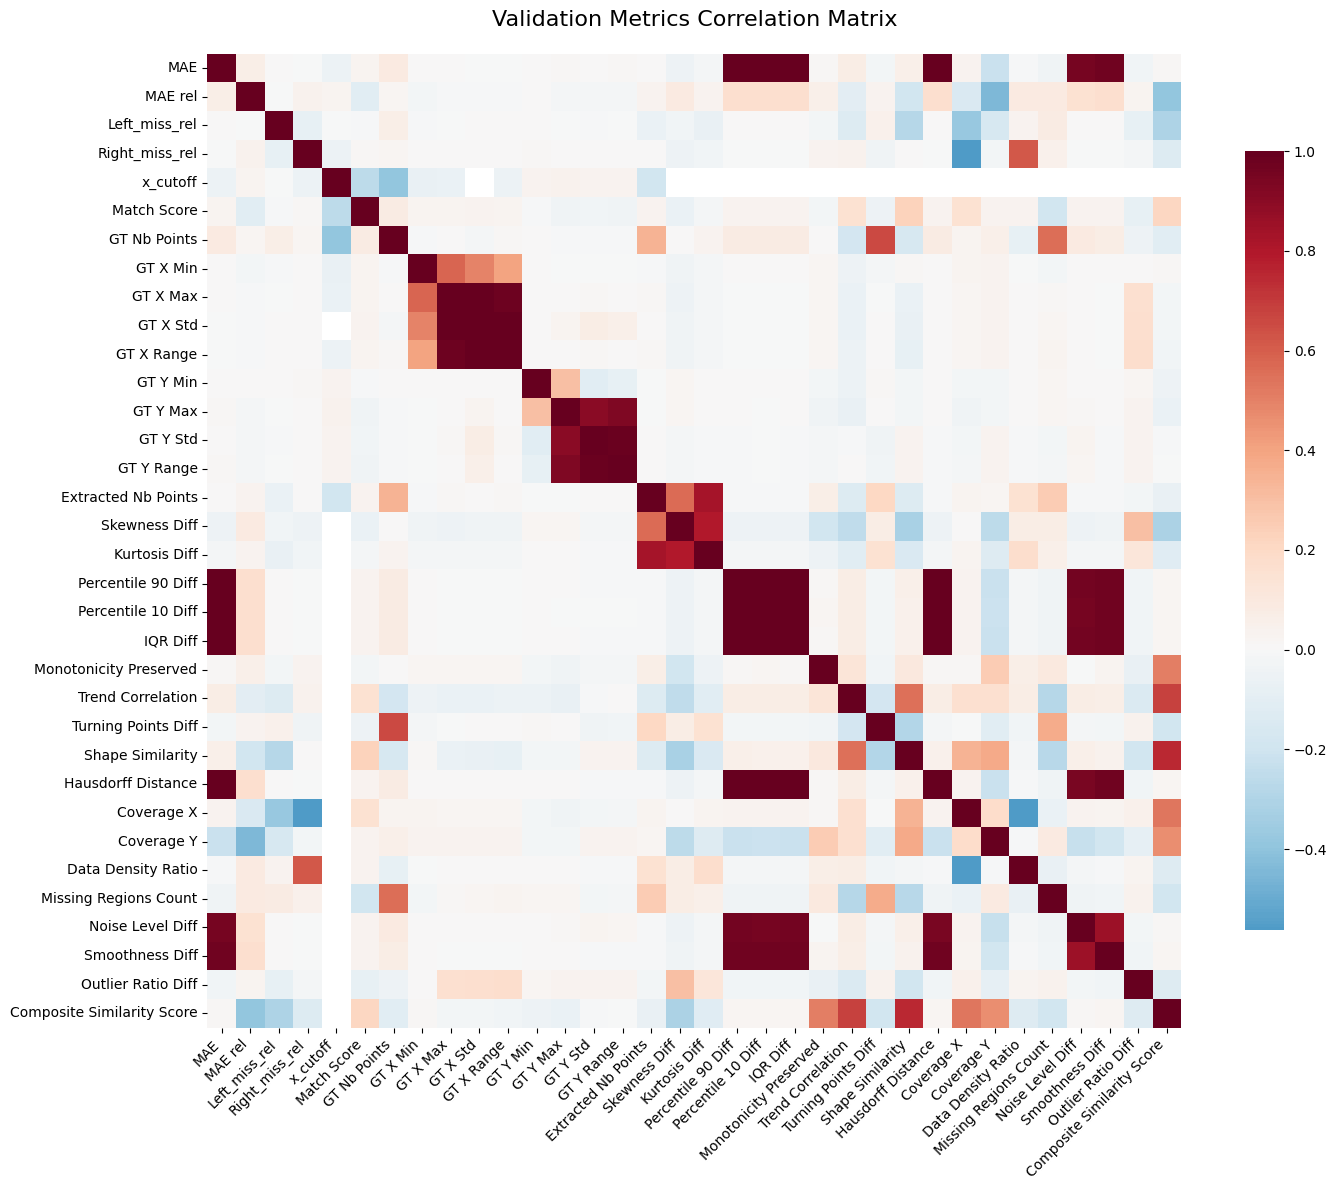

In [8]:
def corr(df):
    # Take only numeric columns
    num_df = df.drop(columns=['Plot Type', 'Image Name', 'Series Name', 'Extracted Name','Match Method', 'Extractor Plot Type'])
    corr_matrix = num_df.corr()
    plt.figure(figsize=(15, 12))
    
    sns.heatmap(corr_matrix, 
                annot=False,  # Set to True if you want values displayed
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Validation Metrics Correlation Matrix', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()


corr(results_df)

=== Principal Component Analysis by Plot Type ===

=== PCA Analysis for line plot ===
Initial DataFrame for line plot: (270, 34)
Columns with NaN: 812
Final DataFrame for line plot: (221, 34)
Number of variables: 34
Number of observations: 221
Variance explained by PC1: 27.35%
Variance explained by PC2: 13.77%
Cumulative variance (PC1+PC2): 41.12%

=== PCA Analysis for scatter ===
Initial DataFrame for scatter: (177, 34)
Columns with NaN: 389
Final DataFrame for scatter: (148, 34)
Number of variables: 34
Number of observations: 148
Variance explained by PC1: 21.81%
Variance explained by PC2: 12.53%
Cumulative variance (PC1+PC2): 34.33%

=== PCA Analysis for bar ===
Initial DataFrame for bar: (418, 16)
Columns with NaN: 418
No complete rows found for bar. Filling with median...
Final DataFrame for bar: (418, 16)
Number of variables: 16
Number of observations: 418
Variance explained by PC1: 39.83%
Variance explained by PC2: 31.07%
Cumulative variance (PC1+PC2): 70.90%

=== PCA Analysis f

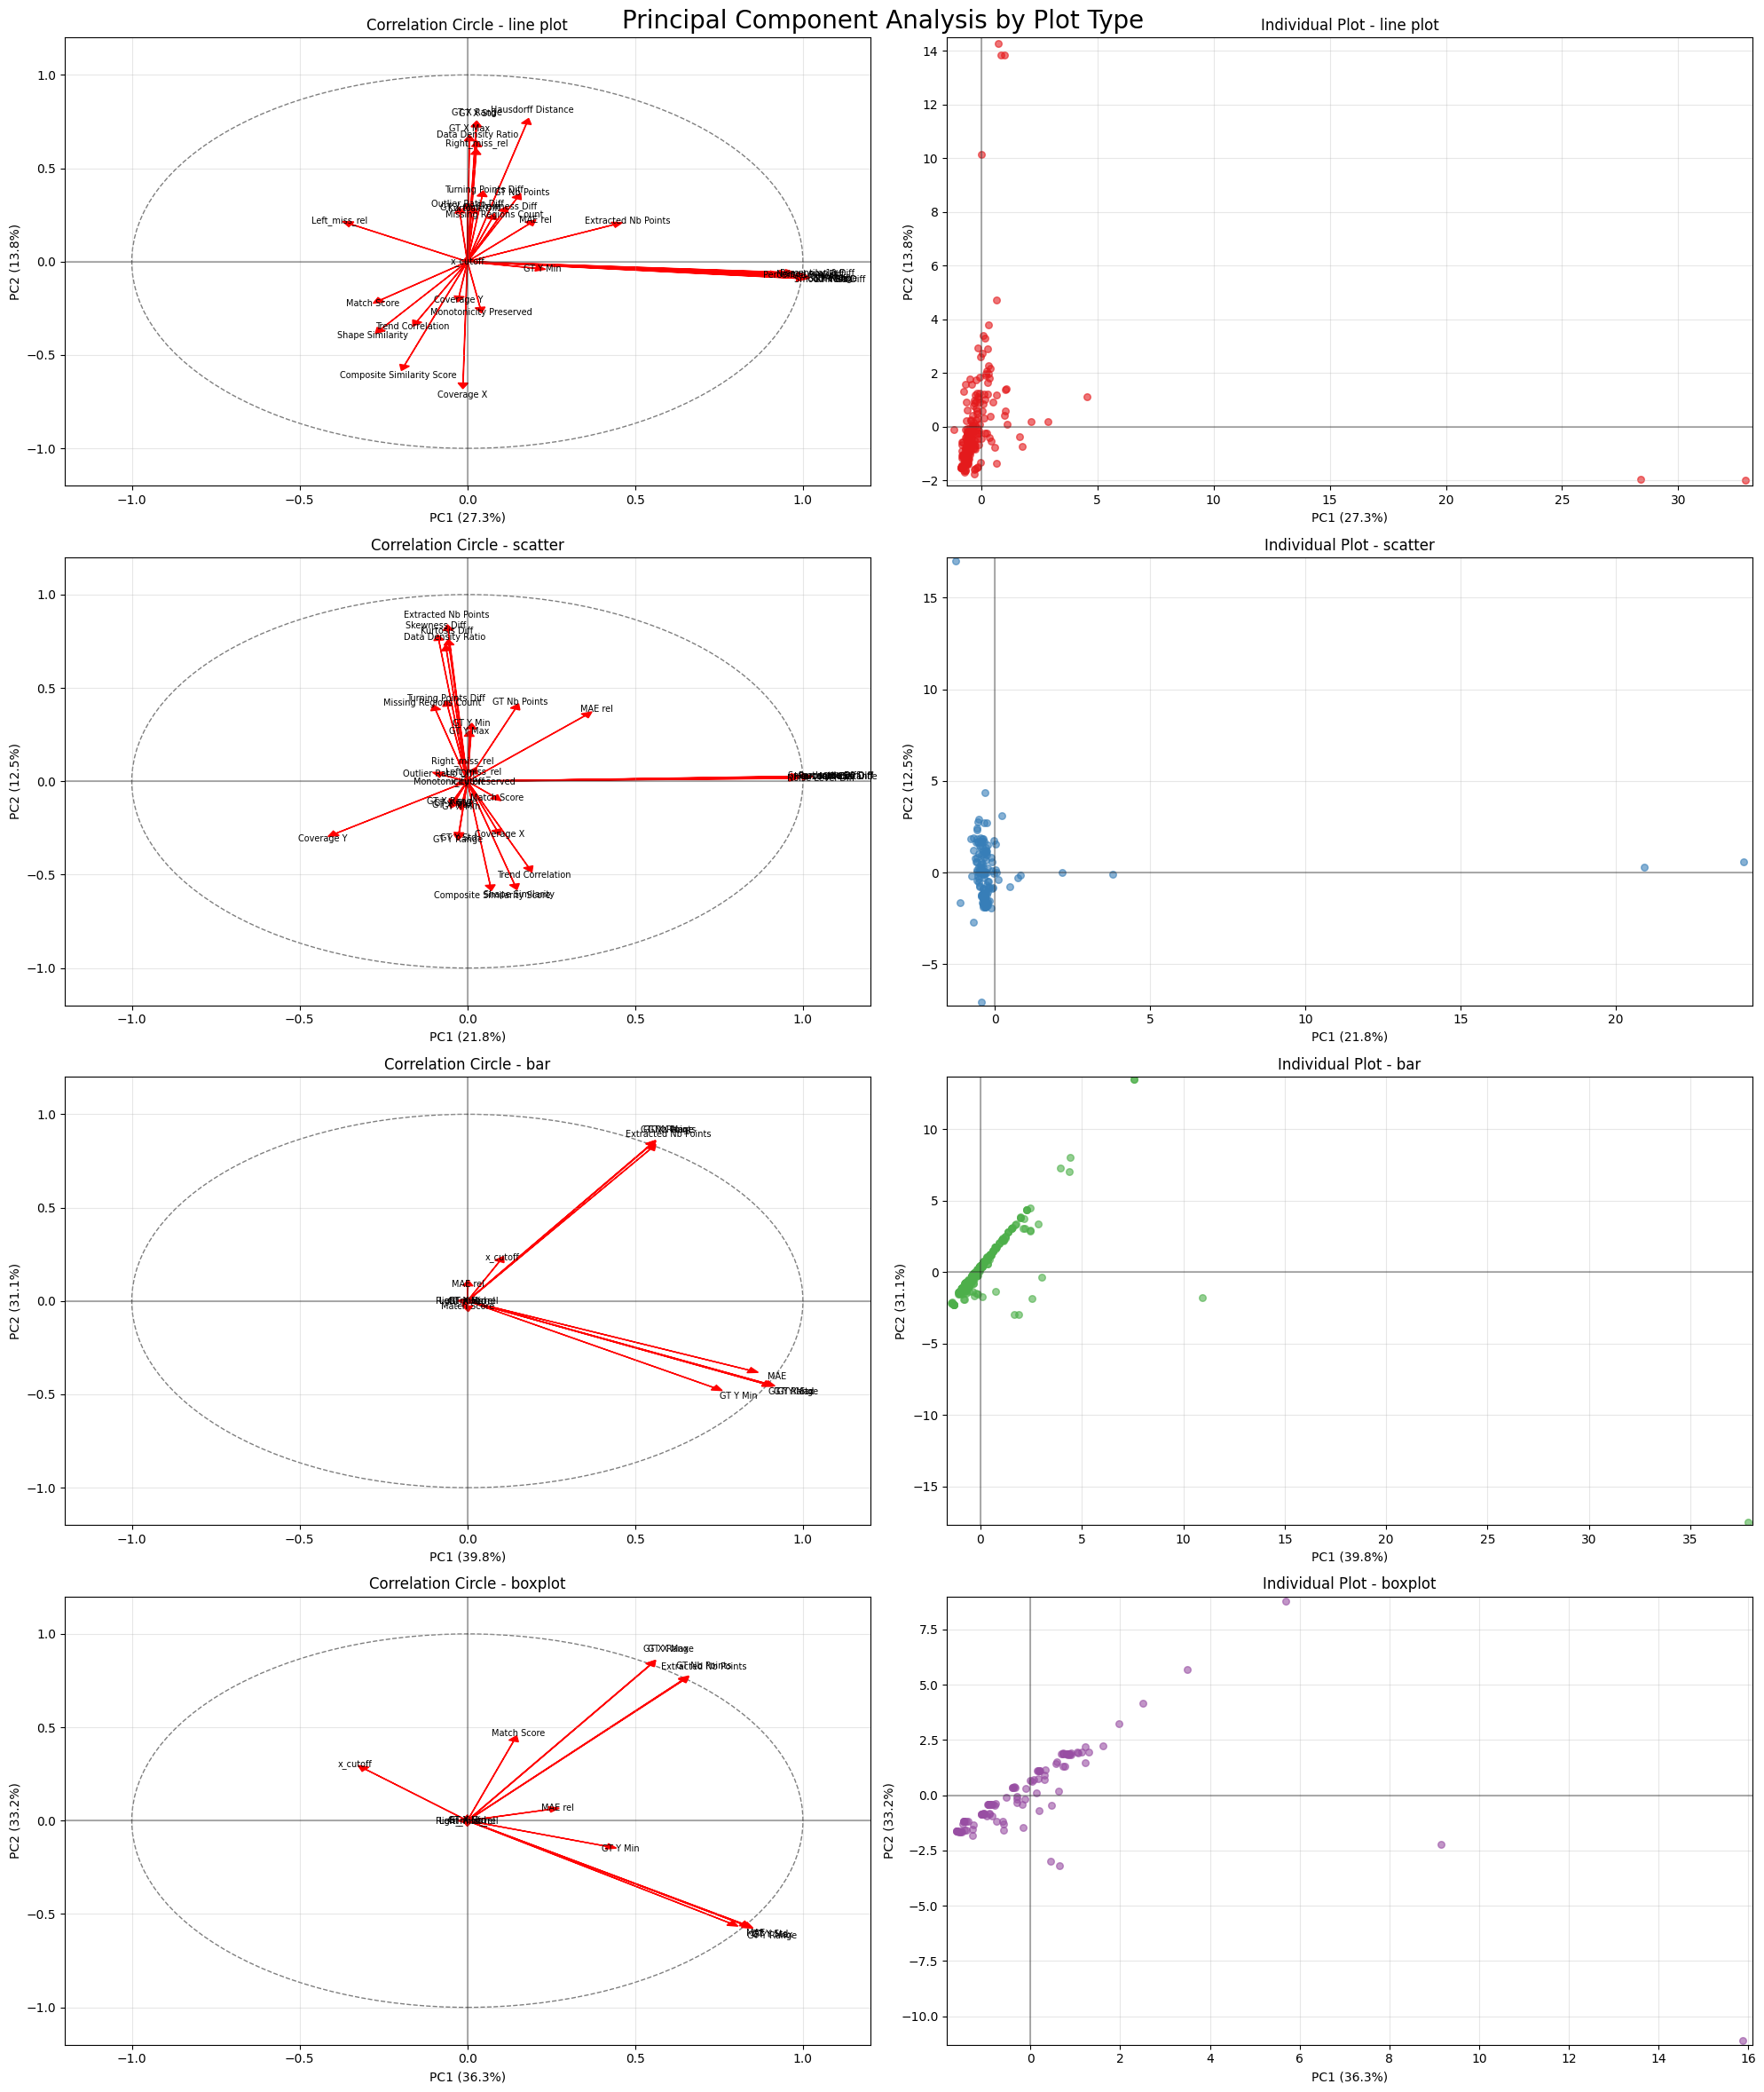


=== Eigenvalue Plots ===


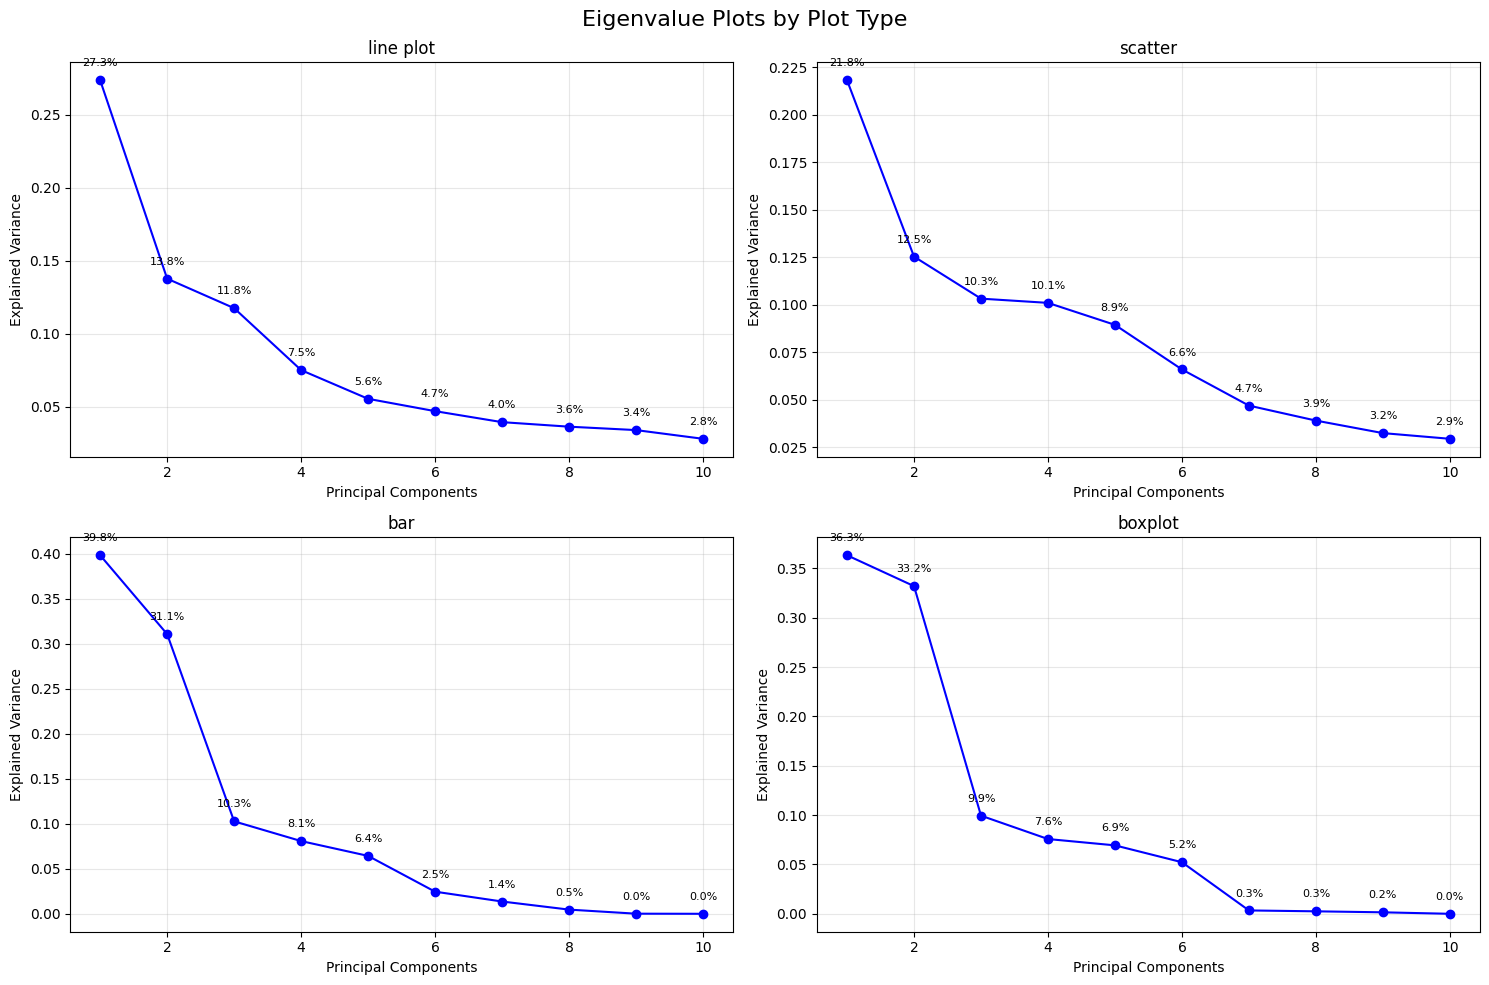


=== Results Summary ===

line plot:
  - Observations: 221
  - Variables: 34
  - PC1+PC2 Variance: 41.1%

scatter:
  - Observations: 148
  - Variables: 34
  - PC1+PC2 Variance: 34.3%

bar:
  - Observations: 418
  - Variables: 16
  - PC1+PC2 Variance: 70.9%

boxplot:
  - Observations: 113
  - Variables: 16
  - PC1+PC2 Variance: 69.6%


In [6]:
def plot_pca_by_plot_type(df, figsize=(20, 24)):
    """
    Principal Component Analysis separated by plot type.
    For bar and boxplot types, excludes columns with too many NaN values.
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Define columns to exclude for bar and boxplot (metrics not calculated)
    excluded_cols_for_bar_box = [
        'Skewness Diff', 'Kurtosis Diff', 'Percentile 90 Diff', 'Percentile 10 Diff', 'IQR Diff',
        'Monotonicity Preserved', 'Trend Correlation', 'Turning Points Diff',
        'Shape Similarity', 'Hausdorff Distance', 'Coverage X', 'Coverage Y',
        'Data Density Ratio', 'Missing Regions Count', 'Noise Level Diff',
        'Smoothness Diff', 'Outlier Ratio Diff', 'Composite Similarity Score'
    ]
    
    # Non-numeric columns to always exclude
    non_numeric_cols = ['Plot Type', 'Image Name', 'Series Name', 'Extracted Name', 'Match Method']
    if 'Extractor Plot Type' in df.columns:
        non_numeric_cols.append('Extractor Plot Type')
    
    # Filter data without errors
    df_no_error = df[(df["Match Method"] != 'error') & (df["Match Method"] != 'extraction_error')]
    
    # Get unique plot types
    plot_types = df_no_error['Plot Type'].unique()
    plot_types = [pt for pt in plot_types if pd.notna(pt)]
    
    # Create figure with subplots for each plot type
    n_plot_types = len(plot_types)
    fig, axes = plt.subplots(n_plot_types, 2, figsize=figsize)
    fig.suptitle('Principal Component Analysis by Plot Type', fontsize=20, y=0.98)
    
    # If only one plot type, ensure axes is 2D
    if n_plot_types == 1:
        axes = axes.reshape(1, -1)
    
    results = {}
    
    for idx, plot_type in enumerate(plot_types):
        print(f"\n=== PCA Analysis for {plot_type} ===")
        
        # Filter data for this plot type
        df_type = df_no_error[df_no_error['Plot Type'] == plot_type].copy()
        
        if len(df_type) < 2:
            print(f"Not enough data for {plot_type} (only {len(df_type)} observations)")
            continue
        
        # Prepare columns according to plot type
        if plot_type in ['bar', 'boxplot']:
            # For bar and boxplot, exclude problematic columns
            cols_to_exclude = non_numeric_cols + excluded_cols_for_bar_box
        else:
            # For other types, exclude only non-numeric columns
            cols_to_exclude = non_numeric_cols
        
        # Remove excluded columns
        num_df = df_type.drop(columns=[col for col in cols_to_exclude if col in df_type.columns])
        
        # Clean data
        print(f"Initial DataFrame for {plot_type}: {num_df.shape}")
        print(f"Columns with NaN: {num_df.isnull().sum().sum()}")
        
        # Remove rows with NaN
        num_df_clean = num_df.dropna()
        
        if len(num_df_clean) == 0:
            print(f"No complete rows found for {plot_type}. Filling with median...")
            num_df_clean = num_df.fillna(num_df.median()).fillna(0)
        
        if len(num_df_clean) < 2:
            print(f"Not enough clean data for {plot_type}")
            continue
        
        print(f"Final DataFrame for {plot_type}: {num_df_clean.shape}")
        
        # Standardization and PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(num_df_clean)
        
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Variable coordinates
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        
        # 1. Correlation circle (PC1 vs PC2)
        ax1 = axes[idx, 0]
        circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.5)
        ax1.add_patch(circle)
        
        for i, var in enumerate(num_df_clean.columns):
            if len(pca.explained_variance_ratio_) > 1:
                ax1.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                         head_width=0.03, head_length=0.03, fc='red', ec='red')
                ax1.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, 
                        fontsize=7, ha='center', va='center', rotation=0)
        
        ax1.set_xlim(-1.2, 1.2)
        ax1.set_ylim(-1.2, 1.2)
        if len(pca.explained_variance_ratio_) > 1:
            ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
            ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax1.set_title(f'Correlation Circle - {plot_type}')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        
        # 2. Individual plot (PC1 vs PC2)
        ax2 = axes[idx, 1]
        if len(pca.explained_variance_ratio_) > 1:
            ax2.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=30, color=plt.cm.Set1(idx))
            
            # Automatically adjust limits
            x_margin = np.std(X_pca[:, 0]) * 0.1
            y_margin = np.std(X_pca[:, 1]) * 0.1
            ax2.set_xlim(X_pca[:, 0].min() - x_margin, X_pca[:, 0].max() + x_margin)
            ax2.set_ylim(X_pca[:, 1].min() - y_margin, X_pca[:, 1].max() + y_margin)
            
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        
        ax2.set_title(f'Individual Plot - {plot_type}')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        
        # Store results
        results[plot_type] = {
            'pca': pca,
            'X_pca': X_pca,
            'loadings': loadings,
            'clean_df': num_df_clean,
            'n_observations': len(num_df_clean),
            'n_variables': len(num_df_clean.columns)
        }
        
        # Display information
        print(f"Number of variables: {len(num_df_clean.columns)}")
        print(f"Number of observations: {len(num_df_clean)}")
        if len(pca.explained_variance_ratio_) > 0:
            print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
        if len(pca.explained_variance_ratio_) > 1:
            print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
            print(f"Cumulative variance (PC1+PC2): {sum(pca.explained_variance_ratio_[:2]):.2%}")
    
    plt.tight_layout()
    plt.show()
    
    return results

def plot_scree_plots_by_type(results, figsize=(15, 10)):
    """
    Creates scree plots for each plot type
    """
    plot_types = list(results.keys())
    n_types = len(plot_types)
    
    if n_types == 0:
        print("No results to display")
        return
    
    # Calculate subplot layout
    cols = 2
    rows = (n_types + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Eigenvalue Plots by Plot Type', fontsize=16)
    
    # Ensure axes is always 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    if n_types == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, plot_type in enumerate(plot_types):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        pca = results[plot_type]['pca']
        n_components = min(10, len(pca.explained_variance_ratio_))
        components = range(1, n_components + 1)
        
        ax.plot(components, pca.explained_variance_ratio_[:n_components], 'bo-', markersize=6)
        ax.set_xlabel('Principal Components')
        ax.set_ylabel('Explained Variance')
        ax.set_title(f'{plot_type}')
        ax.grid(True, alpha=0.3)
        
        # Add percentages on points
        for i, ratio in enumerate(pca.explained_variance_ratio_[:n_components]):
            ax.annotate(f'{ratio:.1%}', 
                       (i+1, ratio), 
                       textcoords="offset points", 
                       xytext=(0,10), 
                       ha='center', fontsize=8)
    
    # Hide empty subplots if necessary
    for idx in range(n_types, rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Execute PCA analysis by plot type
print("=== Principal Component Analysis by Plot Type ===")
try:
    pca_results = plot_pca_by_plot_type(results_df, figsize=(20, 24))
    
    if pca_results:
        print("\n=== Eigenvalue Plots ===")
        plot_scree_plots_by_type(pca_results)
        
        # Results summary
        print("\n=== Results Summary ===")
        for plot_type, result in pca_results.items():
            print(f"\n{plot_type}:")
            print(f"  - Observations: {result['n_observations']}")
            print(f"  - Variables: {result['n_variables']}")
            if len(result['pca'].explained_variance_ratio_) > 1:
                print(f"  - PC1+PC2 Variance: {sum(result['pca'].explained_variance_ratio_[:2]):.1%}")
    else:
        print("No PCA results generated.")
        
except Exception as e:
    print(f"Error during PCA analysis by type: {e}")
    import traceback
    traceback.print_exc()